# 付録
今回の分析に使用したPythonのコードを記述する。

# 目次
1. ディレクトリ構成
2. ライブラリのインストール
3. データの読み込みと前処理
4. 自然言語処理
    1. 形態素解析
    2. TF-IDFによる文章特徴量の生成
5. 主成分分析
6. 予測
    1. 重回帰分析
    2. ランダムフォレスト
    3. サポートベクター回帰
    4. LSTM
7. その他の分析

## 1. ディレクトリ構成
ファイルのディレクトリ構成は下記の通りになっている。

<pre>
./tfidf_lstm/
|- analysis.ipynb #このipynbファイル
|
|- data/
|  |- np_txt/
|  |  |- NP1998/
|  |  |   |- NP199801.txt #1998年01月の月例経済報告のテキストデータ
|  |  |   |- NP199802.txt #1998年02月の月例経済報告のテキストデータ
|  |  |   |- ...
|  |  |   |- NP199812.txt #1998年12月の月例経済報告のテキストデータ
|  |  |
|  |  |- NP1999/
|  |  |- ...
|  |  |- NP2019/
|  | 
|  |- market_data/
|     |- nikkei.csv #日経平均株価の時系列データ
|
|- output/ #分析結果などを出力したディレクトリ
|     |- tfidf.csv #tfidfの結果を出力したCSVファイル
|     |- model.h5 #LSTMのモデルファイル
|
|- support_file/
   |- stopwords.txt #ストップワードとして扱う単語を収録したテキストデータ

</pre>

## 2. ライブラリのインストール

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import sklearn
import keras
import MeCab
import glob
import re
import os

from sklearn.feature_extraction.text import TfidfVectorizer, TfidfTransformer, CountVectorizer
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.metrics import r2_score

from keras.models import Sequential
from keras.layers.core import Dense
from keras.layers.recurrent import LSTM
from keras.optimizers import RMSprop
from keras.callbacks import EarlyStopping
from keras.models import load_model

#豆腐防止用のフォント指定
plt.rcParams["font.family"] = "IPAexGothic"

Using TensorFlow backend.


In [2]:
#使用しているライブラリのバージョンを確認。
'''
"Versions of used main library.
pandas: 0.25.3
numpy: 1.17.4
sklearn: 0.22
tensorflow: 2.0.0
keras: 2.3.1
'''

print("pandas:",pd.__version__)
print("numpy:",np.__version__)
print("sklearn:",sklearn.__version__)
print("tensorflow:",tf.__version__)
print("keras:",keras.__version__)

pandas: 0.25.3
numpy: 1.17.4
sklearn: 0.22
tensorflow: 2.0.0
keras: 2.3.1


## 3. 分析に必要なデータの読み込みと前処理

In [3]:
#パスの指定
NP_TEXT_PATH = "./data/np_txt/"
STOPWORDS_PATH = "./support_file/stopwords.txt"
MARKET_DATA_PATH = "./data/market_data/"

/Users/kengo/.pyenv/versions/anaconda3-5.3.1/envs/tus_research/lib/python3.6/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 360 entries, 1990-02-01 to 2020-01-01
Data columns (total 6 columns):
close           360 non-null float64
open            360 non-null float64
high            360 non-null float64
low             360 non-null float64
volume          360 non-null object
before_ratio    360 non-null object
dtypes: float64(4), object(2)
memory usage: 29.7+ KB
None
              close     open     high      low volume before_ratio
date                                                              
1990-02-01  34592.0  37242.0  37887.0  32443.0      -       -6.98%
1990-03-01  29980.0  34587.0  34588.0  28830.0      -      -13.33%
1990-04-01  29585.0  29980.0  30524.0  27251.0      -       -1.32%
1990-05-01  33131.0  29594.0  33228.0  29519.0      -       11.99%
1990-06-01  31940.0  33110.0  33345.0  31086.0      -       -3.59%


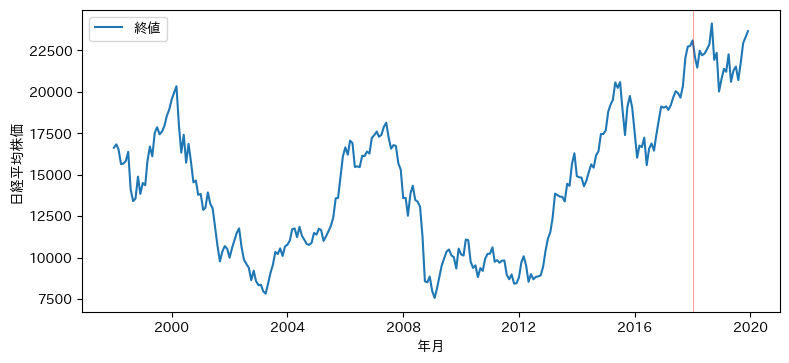

In [4]:
#日経平均株価
nikkei = pd.read_csv(MARKET_DATA_PATH + "nikkei.csv")

nikkei.columns = ["date", "close", "open", "high", "low", "volume", "before_ratio"]
nikkei["date"] = pd.to_datetime(nikkei["date"], format="%Y年%m月")
nikkei.set_index("date", inplace=True)

#終値
close = nikkei["close"].loc["1998":"2019"]

plt.figure(figsize=(9,4), dpi=100)
plt.plot(close)
plt.axvline("2018", c="red", alpha=0.4, linewidth=0.7)
plt.xlabel("年月")
plt.ylabel("日経平均株価")
plt.legend(["終値"])

print(nikkei.info())
print(nikkei.head())

In [5]:
#ストップワード
with open(STOPWORDS_PATH) as f:
    stop_words = f.read().split("\n")
    
print("例：",stop_words[0:5])

例： ['あそこ', 'あたり', 'あちら', 'あっち', 'あと']


## 4. 自然言語処理

### A. 形態素解析

In [6]:
#前処理用関数を定義
def preprocessing(text):
    
    """
    テキストから不要な記号や数字を取り除く。
    
    Parameters
    ----------
    text : str
        処理対象の文章。
        
    Returns
    -------
    text : str
        不要な記号や数字が取り除かれた文章。
    """
    
    text = re.sub(r'[0-9]+', '', text)
    text = re.sub(r'(https?|ftp)(:\/\/[-_\.!~*\'()a-zA-Z0-9;\/?:\@&=\+\$,%#]+)', '' , text)
    text = re.sub(r'[【】]', '', text) 
    text = re.sub(r'[→]', '', text) 
    text = re.sub(r'[!-~]', '',text)
    text = re.sub(r'[︰-＠]', '', text)
    text = re.sub(' ', '', text)
    text = re.sub(r'\n+', '\n', text) 
    text = re.sub(r'[()]', '', text)
    text = text.replace(' ', '')
    return text

In [7]:
tagger = MeCab.Tagger('-Ochasen -d /usr/local/lib/mecab/dic/mecab-ipadic-neologd')

def create_corpus(text):
    
    """
    テキストを形態素解析し、スペースを挟んだ単語のリストに変換する。
    
    Parameters
    ----------
    text : str
        処理対象の文章。
        
    Returns
    -------
    corpus : list of str
        単語が' 'を間に挟んだ文章に変換されたリスト
    """
    
    sentence = []
    
    word_info_list = tagger.parse(text).split("\n")
    
    for word_info in word_info_list[:-2]:
        word_info = word_info.split("\t")
        word = word_info[0] #単語
        #yomi = word_info[1] #読み仮名
        original = word_info[2] #原型
        word_class = word_info[3].split("-")[0] #品詞
    
        if original not in stop_words and word_class in ["名詞"]:
            sentence.append(original)
            
    corpus = " ".join(sentence)
    
    return corpus

In [ ]:
#パスを指定し、ファイル一覧を取得する。
np_txt_path_list =  sorted(glob.glob(NP_TEXT_PATH + "*/*.txt"))

#テキストを格納する辞書を作成する。
text_dict = {}
text_list = []
year_month_list = []

for np_txt_path in np_txt_path_list[0:]:
    
    #パスから6桁の数値を取得する。(年月)
    year_month = re.findall(r'[0-9]{6}', np_txt_path)[0]
    year_month_list.append(year_month)
    upper = year_month[0:4]
    lower = year_month[4:]

    #テキストの読み込み
    f = open(np_txt_path)
    text = f.read()

    if upper not in text_dict:
        text_dict[upper] = {}
    
    text = preprocessing(text)
    text_list.append(create_corpus(text))
    
    text_dict[upper][lower] = text 

### B. TF-IDFによる文章特徴量の生成

In [ ]:
count_vectorizer = CountVectorizer()
word_corpus = count_vectorizer.fit_transform(text_list)

ttf = TfidfTransformer(norm="l2", use_idf=True, smooth_idf=True, sublinear_tf=False)
tfidf = ttf.fit_transform(word_corpus)

#tfidf
tfidf_df = pd.DataFrame(tfidf.toarray(), columns=count_vectorizer.get_feature_names(), index=year_month_list)
tfidf_df.index = pd.to_datetime(tfidf_df.index, format='%Y%m')

#tf
tf_df = pd.DataFrame(word_corpus.toarray(), columns=count_vectorizer.get_feature_names(), index=year_month_list)
tf_df.index = pd.to_datetime(tfidf_df.index, format='%Y%m')

#idf
idf_df = pd.Series(ttf.idf_,index=count_vectorizer.get_feature_names())

#保存
tfidf_df.to_csv("./output/tfidf_result.csv")

tfidf_df.head()

## 5. 主成分分析

In [ ]:
#主成分分析
pca = PCA(n_components=30)
feature = pca.fit_transform(tfidf_df)
feature_df = pd.DataFrame(index=tfidf_df.index, columns=["comp_"+str(n) for n in range(1, pca.n_components_+1)], data=feature)
feature_df.head()

In [ ]:
#累積寄与率の可視化
cumsum = 0
for num ,explained_variance_ratio in enumerate(pca.explained_variance_ratio_):
    cumsum += explained_variance_ratio
    if cumsum >= 0.75:
        print("Cumulative contribution:",cumsum)
        print("over 0.75 index number:",num)
        break
        
plt.figure(figsize=(6,4),dpi=100)
plt.plot(pca.explained_variance_ratio_.cumsum())

plt.axvline(num, linestyle="--",color="green")
plt.axhline(0.8, linestyle="-.", color="red")
plt.xticks(np.arange(0, 280 + 1, 10), rotation=0)
plt.xlim(0,pca.n_components)
plt.ylim(0,1)

plt.title("contribution cumlative rate")
plt.ylabel("Contribution rate")
plt.xlabel("component")
plt.grid(True)
plt.xticks([0, 10, num, 20, 30])

plt.legend(["cumlative rate", "over 0.75 index"])
plt.show()

## 6. 予測 

In [ ]:
#データセット作成用の関数を定義
def create_dataset(data, feature_columns, target_columns, train_data_length):
    
    """
    scikit-learnに対応したデータセットに変換する。

    Parameters
    ----------
    data : pandas.DataFrame
        変換対象のデータフレーム
    feature_columns : list of str
        予測・分類のために使用したい特徴量の列名
    target_columns : str
        予測・分類したい対象の列名
    train_data_length : int
        訓練データとして使用するデータの長さ
    
    Returns
    -------
    X_train : list
        訓練データの特徴量
    y_train : list
        訓練データの予測・分類対象
    X_test : list
        テストデータの特徴量
    y_test : list
        テストデータの予測・分類対象
    """
    
    X_train = data[feature_columns].iloc[0:train_data_length].values
    X_test = data[feature_columns].iloc[train_data_length:].values
    y_train = data[target_columns].iloc[0:train_data_length].values
    y_test = data[target_columns].iloc[train_data_length:].values
    
    return X_train, y_train, X_test, y_test

In [ ]:
#mergeするDataFrameはtfidf_df or feature_dfを選択する。
merge_df = feature_df.iloc[:,0:num].join(close)

minmax = MinMaxScaler(feature_range=(0,1))
merge_df[:] = minmax.fit_transform(merge_df)

#今回は訓練データの長さを200、テストデータの長さを残りの64にした。
X_train, y_train, X_test, y_test = create_dataset(merge_df, 
                                                  merge_df.columns[:-1], 
                                                  merge_df.columns[-1], 
                                                  train_data_length=240)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

### A. 重回帰分析

In [ ]:
lr = LinearRegression()
lr.fit(X_train, y_train)
lr_pred = lr.predict(X_test)

print("mae:",mean_absolute_error(y_test, lr_pred))
print("mse:",mean_squared_error(y_test, lr_pred))

### B. サポートベクター回帰

In [ ]:
svr = SVR(C=900, epsilon=0.007,kernel='rbf', gamma='auto')
svr.fit(X_train, y_train)
svr_pred = svr.predict(X_test)

print("mae:",mean_absolute_error(y_test, svr_pred))
print("mse:",mean_squared_error(y_test, svr_pred))

### C. ランダムフォレスト

In [ ]:
rf = RandomForestRegressor(n_estimators=100, max_depth=None, random_state=0, criterion="mse")
rf.fit(X_train, y_train)
rf_pred = rf.predict(X_test)

print("mae:",mean_absolute_error(y_test, rf_pred))
print("mse:",mean_squared_error(y_test, rf_pred))

### D. LSTM

In [ ]:
#データ整形用の関数
def prepare_data_for_lstm(df, feature_columns, target_column, train_data_length, window_size, normalized=False):
    
    """
    kerasに対応したデータセットに変換する。

    Parameters
    ----------
    df : pandas.DataFrame
        変換対象のデータフレーム
    feature_columns : list of str
        予測・分類のために使用したい特徴量の列名
    target_columns : str
        予測・分類したい対象の列名
    train_data_length : int
        訓練データとして使用するデータの長さ
    window_size : int
        時間窓の長さ
    normalized : bool
        Falseである場合、正規化を行う。Trueである場合行わない。
    
    Returns
    -------
    X_train : list
        訓練データの特徴量
    y_train : list
        訓練データの予測・分類対象
    X_test : list
        テストデータの特徴量
    y_test : list
        テストデータの予測・分類対象
    """
    
    print("feature:",feature_columns)
    print("target:", target_column)
    
    feature_columns.append(target_column)
    columns = feature_columns
    values = df[columns].values
    
    if normalized == False:
        sc = MinMaxScaler()
        values = sc.fit_transform(values)
        
    #create dataset
    dataset = []
    for t in range(0, len(df) - window_size):
        dataset.append(values[t:t+window_size])
    dataset = np.asarray(dataset)
    print("shape of dataset:",dataset.shape)
    
    #split data 
    X_train = dataset[0:train_data_length, :, :-1] 
    y_train = dataset[0:train_data_length, 0, -1]
    X_test = dataset[train_data_length:,: ,:-1]
    y_test = dataset[train_data_length:, 0, -1]
    
    return X_train, y_train, X_test, y_test

In [ ]:
window = 60
train_size = 180 #len(merge_df) - window - 12
target_name = "close"

print(train_size)

merge_df = feature_df.iloc[:, 0:12].join(close)

X_train, y_train, X_test, y_test = prepare_data_for_lstm(merge_df,
                                                         feature_columns=merge_df.columns[:-1].tolist(),
                                                         target_column=target_name,
                                                         train_data_length=train_size,
                                                         window_size=window,
                                                         normalized=False)

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

In [ ]:
#モデルを読み込む場合(推奨)
model = keras.models.load_model('./output//model.h5', compile=False)

In [ ]:
#モデル構築(予め出力しているモデルのデータがあるので、そちらの読み込みを推奨)

#乱数の固定
np.random.seed(1)
tf.random.set_seed(1)

#LSTMのモデル構築。
#今回はLSTM層と全結合層を一つずつ使うモデルを構築した。
model = Sequential() 
model.add(LSTM(units=1024,
               input_shape=(window, len(merge_df.columns)-1), 
               return_sequences=False, 
               ))
model.add(Dense(units=1, 
                activation="linear"))

#最適化アルゴリズムにRMSpropを使用。
#学習率は過学習防止のため1e-5にしている。
optimizer = RMSprop(learning_rate=1e-5) 
model.compile(loss="mse", optimizer=optimizer)

#学習
model.fit(x=X_train, y=y_train, batch_size=1, epochs=1000, verbose=2, validation_split=0.25,
          callbacks=[EarlyStopping(monitor='val_loss', patience=5, verbose=2, mode='auto')])

print("complete!")

In [ ]:
#モデルの保存
#model.save('/users/kengo/model.h5', include_optimizer=False)

In [ ]:
#LSTMの精度の計算
print("mae", mean_absolute_error(y_test, model.predict(X_test).ravel()))
print("mse", mean_squared_error(y_test, model.predict(X_test).ravel()))

In [ ]:
#決定係数
r2_score(y_test, model.predict(X_test).ravel())

## 7. その他の分析

In [ ]:
#各主成分における寄与率を計算する。
comp_df = pd.DataFrame(pca.components_.T, columns=["主成分" + str(n) for n in range(1,pca.n_components_+1)], index=tfidf_df.columns)

factor_loading = pd.DataFrame(index=range(1,11))
for col_name, item in comp_df.iteritems():
    factor_loading[col_name] = abs(item).sort_values(ascending=False)[0:10].index
    
factor_loading.iloc[:, 0:30].head(10)

In [ ]:
#それぞれの因子負荷量のランキングを表示する。
factor_loading.iloc[:, 0:10].head(10)

In [ ]:
factor_loading.iloc[:, 10:20].head(10)

In [ ]:
factor_loading.iloc[:, 20:30].head(10)

In [ ]:
#特徴重要度の可視化
plt.figure(figsize=(5,4),dpi=100)
rf_feature_importance = pd.Series(rf.feature_importances_, index=feature_df.iloc[:,0:rf.n_features_].columns)
rf_feature_importance.sort_values(ascending=False).plot(kind="bar", title="feature importance")

In [ ]:
#総単語数の可視化
plt.figure(figsize=(8,5), dpi=100)
tf_df.sum(axis=1).plot()
plt.xlabel("date")
plt.ylabel("word count")
plt.show()

In [ ]:
#重回帰分析の回帰係数
print("intercept:",lr.intercept_)
print(pd.Series(lr.coef_, index=merge_df.columns[:-1], name="linear_coef"))